In [1]:
import warnings
warnings.filterwarnings("ignore")

import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import functools
import nltk
import xgboost as xgb
import re
import seaborn as sn
import pandas as pd

from emoji import UNICODE_EMOJI

import sklearn
from sklearn.model_selection import train_test_split, cross_validate # for splitting data into train and test samples
from sklearn.svm import SVC, LinearSVC # for Support Vector Classification baseline model
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # for model evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

from difflib import get_close_matches

contents = []
with open("rumour-annotation-2_annotations.json", 'rb') as j:
     contents.append(json.loads(j.read()))

contents2 = []
with open("rumour-annotation-3_annotations.json", 'rb') as j:
     contents2.append(json.loads(j.read()))

contents3 = []
with open("rumour-annotation_annotations.json", 'rb') as j:
     contents3.append(json.loads(j.read()))

contents4 = []
with open("rumour-annotation-4_annotations.json", 'rb') as j:
     contents4.append(json.loads(j.read()))


Text(0, 0.5, 'frequency')

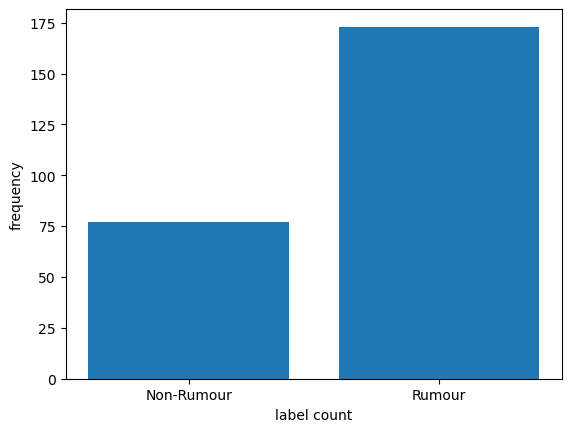

In [2]:
annotations = contents[0]["examples"]

classnames = []
for i in range(0,len(annotations)):
    classnames.append(annotations[i]["classifications"][0]["classname"])

unique, counts = np.unique(classnames, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("label count")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

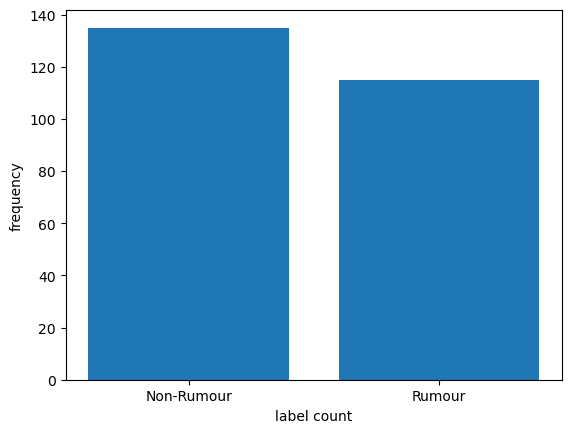

In [3]:
annotations2 = contents2[0]["examples"]

classnames2 = []
for i in range(0,len(annotations2)):
    classnames2.append(annotations2[i]["classifications"][0]["classname"])

unique, counts = np.unique(classnames2, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("label count")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

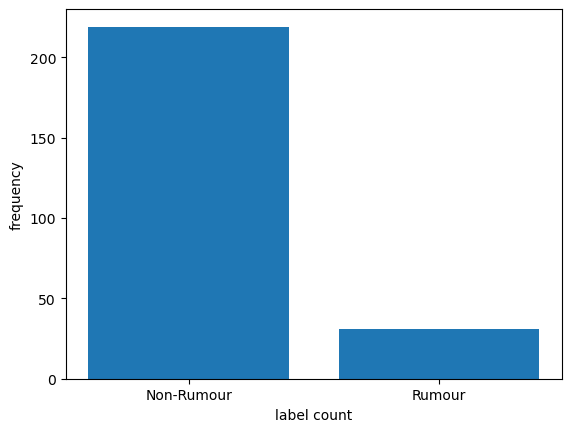

In [4]:
annotations3 = contents3[0]["examples"]

classnames3 = []
for i in range(0,len(annotations3)):
    classnames3.append(annotations3[i]["classifications"][0]["classname"])

unique, counts = np.unique(classnames3, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("label count")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

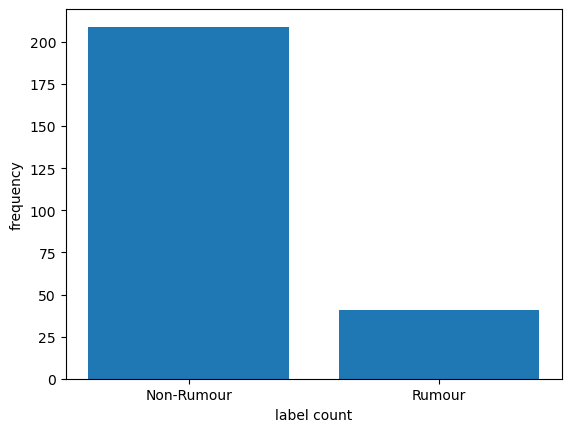

In [5]:
annotations4 = contents4[0]["examples"]

classnames4 = ["Rumour"]
for i in range(1,len(annotations4)):
    classnames4.append(annotations4[i]["classifications"][0]["classname"])

unique, counts = np.unique(classnames4, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("label count")
plt.ylabel("frequency")

In [6]:
file = open('#jinekdata.txt', 'r')
count = 0
tweets = []

while True:
    count += 1
 
    # Get next line from file
    line = file.readline()
 
    # if line is empty
    # end of file is reached
    if not line:
        break
    #the encoding needs to be specified for the code to work on Windows. on Pop Os, it needs to be commented out.
    tweets.append(json.loads(line))#,encoding="utf-8"))

tweets = tweets[0]
    
data1 = []
for i in range(len(tweets)):
    for j in range(len(tweets[i]["data"])):
        temp = []
        temp.append(tweets[i]["data"][j])
        user = [k for k in tweets[0]["includes"]["users"] 
                if k["id"] == tweets[i]["data"][j]["author_id"]]
        temp.append(user)
        temp.append("#jinek")
        temp.append(-1)
        temp.append("n.a.")
        data1.append(temp)
len(data1)

175780

In [7]:
file1 = open('#vleestaksdata.txt', 'r')
count = 0
tweets = []

while True:
    count += 1
 
    # Get next line from file
    line = file1.readline()
 
    # if line is empty
    # end of file is reached
    if not line:
        break
    #the encoding part needs to be specified for the code to work on Windows. on Pop Os, it needs to be commented out.
    tweets.append(json.loads(line))#,encoding="utf-8"))
    
tweets = tweets[0]
    
data2 = []
for i in range(len(tweets)):
    for j in range(len(tweets[i]["data"])):
        temp = []
        temp.append(tweets[i]["data"][j])
        user = [k for k in tweets[0]["includes"]["users"] 
                if k["id"] == tweets[i]["data"][j]["author_id"]]
        temp.append(user)
        temp.append("#vleestaks")
        temp.append(-1)
        temp.append("n.a.")
        data2.append(temp)
len(data2)

10542

In [8]:
file = open('#inflatiedata.txt', 'r')
count = 0
tweets = []

while True:
    count += 1
 
    # Get next line from file
    line = file.readline()
 
    # if line is empty
    # end of file is reached
    if not line:
        break
    #the encoding part needs to be specified for the code to work on Windows. on Pop Os, it needs to be commented out.
    tweets.append(json.loads(line))#,encoding="utf-8"))
    
tweets = tweets[0]
    
data3 = []
for i in range(len(tweets)):
    for j in range(len(tweets[i]["data"])):
        temp = []
        temp.append(tweets[i]["data"][j])
        user = [k for k in tweets[0]["includes"]["users"] 
                if k["id"] == tweets[i]["data"][j]["author_id"]]
        temp.append(user)
        temp.append("#inflatie")
        temp.append(-1)
        temp.append("n.a.")
        data3.append(temp)
len(data3)

39278

In [9]:
data = data1 + data2 + data3

In [10]:
import time 
def get_features(data):

    features = []

    for x in range(0,len(data)):
        temp = []
        if data[x][1] != []:
            followers_count = data[x][1][0]["public_metrics"]["followers_count"]
            temp.append(followers_count)
        else:
            temp.append(0)

        tweetcount = -1 
        if data[x][1] != []:        
            tweetcount = data[x][1][0]["public_metrics"]["tweet_count"]
            temp.append(tweetcount)
        else:
            temp.append(0)

        qmarks = "?" in data[x][0]["text"]
        temp.append(int(qmarks))

        if data[x][1] != []:
            verified = data[x][1][0]["verified"]
            temp.append(int(verified))    
        else:
            temp.append(0)

        accountlife = time.mktime(time.localtime()) - time.mktime(time.strptime(data[x][0]["created_at"], "%Y-%m-%dT%H:%M:%S.000Z"))
        temp.append(accountlife)

        if data[x][1] != []:    
            ratio = (data[x][1][0]["public_metrics"]["followers_count"]+1)/(data[x][1][0]["public_metrics"]["following_count"]+2)
            temp.append(ratio)
        else:
            temp.append(0)

        emark = "!" in data[x][0]["text"]
        temp.append(int(emark))

        capitalletters = sum(1 for c in data[x][0]["text"] if c.isupper())/sum(1 for c in data[x][0])
        temp.append(capitalletters)

        retweet_count = data[x][0]["public_metrics"]["retweet_count"]
        temp.append(retweet_count)

        hashtags = "#" in data[x][0]["text"]
        temp.append(int(hashtags))

        if data[x][1] != []:
            following = data[x][1][0]["public_metrics"]["following_count"]
            temp.append(following)
        else:
            temp.append(0)

        text_length = len(data[x][0]["text"])
        temp.append(text_length)

        if data[x][1] != []:    
            listed_count = data[x][1][0]["public_metrics"]["listed_count"]
            temp.append(listed_count)
        else:
            temp.append(0)

        emoticons = True in [s in UNICODE_EMOJI['en'] for s in data[x][0]["text"]]
        temp.append(int(emoticons))

        #reply_count = data[x][0]["public_metrics"]["reply_count"]
        #temp.append(reply_count)

        #quote_count = data[x][0]["public_metrics"]["quote_count"]
        #temp.append(quote_count)

        like_count = data[x][0]["public_metrics"]["like_count"]
        temp.append(like_count)

        if data[x][1] != []:
            timeafterposting = time.mktime(time.strptime(data[x][1][0]["created_at"],"%Y-%m-%dT%H:%M:%S.000Z")) - time.mktime(time.strptime(data[x][0]["created_at"],"%Y-%m-%dT%H:%M:%S.000Z"))
            temp.append(timeafterposting)
        else:
            temp.append(0)

        #pos_tags = nltk.pos_tag(nltk.word_tokenize(data[x][0]["text"]))
        #temp.append(pos_tags)

        activity = accountlife/tweetcount
        temp.append(activity)
        
#         #text
        temp.append(data[x][0]["text"])
        
        #hashtag
        temp.append(data[x][2])
        
        #upsample group 
        temp.append(str(data[x][3])+str(data[x][2]))
        features.append(temp)

        temp.append(data[x][3])
        features.append(temp)
        

    return features
        

In [11]:
sample1 = [annotations[i]["content"] for i in range(len(annotations))]
sample2 = [annotations2[i]["content"] for i in range(len(annotations2))]
sample3 = [annotations3[i]["content"] for i in range(len(annotations3))]
sample4 = [annotations4[i]["content"] for i in range(len(annotations4))]

sample = [sample1 + sample2 + sample3 + sample4]

annotations = annotations + annotations2 + annotations3 + annotations4


annotators = ["A", "B", "C", "D"]

texts = [data[i][0]["text"] for i in range(len(data))]
for i in range(len(texts)):
    for s in sample:
        if texts[i] in s:
            if annotations[s.index(texts[i])]["classifications"] != []:
                label = annotations[s.index(texts[i])]["classifications"][0]["classname"]
                data[i][4] = annotators[sample.index(s)]
                if label == "Rumour":
                    data[i][3] = 1
                elif label == "Non-Rumour":
                    data[i][3] = 0
            else:
                data[i][3] = 1

In [12]:
features = get_features(data)

In [14]:
columns = ["followers_count",
          "tweet_count",
          "question_marks",
          "verified",
          "accountlife",
          "followers_ratio",
          "exclamation_marks",
          "capital letters",
          "retweet_count",
          "hashtags",
          "following",
          "text length",
          "listed_count",
          "emoticons",
          "like_count",
          "time_after_posting",
          "activity",
          "text",
          "hashtag",
          "upsample_group",
          "label"]
df = pd.DataFrame(data=features, index=None, columns=columns)

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
scaler.fit(df[columns[:-4]].to_numpy())
df[columns[:-4]] = scaler.transform(df[columns[:-4]].to_numpy())
df

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,text length,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,...,0.322581,0.000800,0.0,0.0,0.648938,0.981257,#buitenhof\n\nGaaaaaaaaf land NL\n\n#rutte @Mi...,#jinek,-1#jinek,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195,0.000000,0.000000,0.0,0.0,0.993064,0.000000,0.0,0.049566,0.000000,1.0,...,0.144605,0.000000,0.0,0.0,1.000000,0.006306,Slim Beleggen - Weekend TV http://bit.ly/deDzP...,#inflatie,-1#inflatie,-1
451196,0.000000,0.000000,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1
451197,0.000000,0.000000,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1
451198,0.000000,0.000000,0.0,0.0,0.997605,0.000000,0.0,0.008261,0.000000,1.0,...,0.149055,0.000000,0.0,0.0,1.000000,0.002177,@desmodus Lastig. En het erge vind ik dus dat ...,#inflatie,-1#inflatie,-1


In [17]:
df_j = df[df["hashtag"]=="#jinek"]
df_j

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,text length,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.000000,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.000000,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.000000,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.000000,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,...,0.322581,0.000800,0.0,0.000000,0.648938,0.981257,#buitenhof\n\nGaaaaaaaaf land NL\n\n#rutte @Mi...,#jinek,-1#jinek,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351555,0.000000,0.000000,0.0,0.0,0.084262,0.000000,0.0,0.033044,0.079516,1.0,...,0.149055,0.000000,0.0,0.000000,1.000000,0.832535,"RT @ArjandeKok1: Wat een denigrerende, mensont...",#jinek,-1#jinek,-1
351556,0.000000,0.000000,0.0,0.0,0.084262,0.000000,1.0,0.012392,0.000000,1.0,...,0.156841,0.000000,0.0,0.000096,1.000000,0.832535,@Anous01 Wat een sneue verschijning die #baud...,#jinek,-1#jinek,-1
351557,0.000000,0.000000,0.0,0.0,0.084262,0.000000,1.0,0.012392,0.000000,1.0,...,0.156841,0.000000,0.0,0.000096,1.000000,0.832535,@Anous01 Wat een sneue verschijning die #baud...,#jinek,-1#jinek,-1
351558,0.000000,0.000000,0.0,0.0,0.084262,0.000000,0.0,0.012392,0.000327,1.0,...,0.161290,0.000000,0.0,0.001244,1.000000,0.832535,"@debroervanroos Een pijnlijke waarheid, over h...",#jinek,-1#jinek,-1


In [18]:
df_v = df[df["hashtag"]=="#vleestaks"]
df_v

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,text length,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label
351560,0.000427,0.039362,0.0,0.0,0.000009,0.000059,0.0,0.016522,0.054319,1.0,...,0.147942,0.000000,0.0,0.000000,0.186520,0.981251,RT @Woutel: De reacties op de hashtags #vleest...,#vleestaks,0#vleestaks,0
351561,0.000427,0.039362,0.0,0.0,0.000009,0.000059,0.0,0.016522,0.054319,1.0,...,0.147942,0.000000,0.0,0.000000,0.186520,0.981251,RT @Woutel: De reacties op de hashtags #vleest...,#vleestaks,0#vleestaks,0
351562,0.000034,0.003380,0.0,0.0,0.000010,0.000037,0.0,0.012392,0.001309,1.0,...,0.149055,0.000267,0.0,0.000000,0.928018,0.981271,"RT @eten_is_weten: #vleestaks\n\n""Eigenlijk is...",#vleestaks,-1#vleestaks,-1
351563,0.000034,0.003380,0.0,0.0,0.000010,0.000037,0.0,0.012392,0.001309,1.0,...,0.149055,0.000267,0.0,0.000000,0.928018,0.981271,"RT @eten_is_weten: #vleestaks\n\n""Eigenlijk is...",#vleestaks,-1#vleestaks,-1
351564,0.000074,0.001142,0.0,0.0,0.000010,0.000003,0.0,0.020653,0.029450,0.0,...,0.149055,0.000267,0.0,0.000000,0.872271,0.981313,RT @WassenbergFrank: Bij productie vlees worde...,#vleestaks,-1#vleestaks,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372639,0.000000,0.000000,0.0,0.0,0.971521,0.000000,0.0,0.004131,0.000000,1.0,...,0.053393,0.000000,0.0,0.000000,1.000000,0.025891,Misschien moet ik zelf gewoon een koe kopen #v...,#vleestaks,-1#vleestaks,-1
372640,0.000000,0.000000,1.0,0.0,0.971522,0.000000,0.0,0.004131,0.000000,1.0,...,0.146830,0.000000,0.0,0.000000,1.000000,0.025891,"#vleestaks, #vettaks, #bonustaks, wie verzint ...",#vleestaks,-1#vleestaks,-1
372641,0.000000,0.000000,1.0,0.0,0.971522,0.000000,0.0,0.004131,0.000000,1.0,...,0.146830,0.000000,0.0,0.000000,1.000000,0.025891,"#vleestaks, #vettaks, #bonustaks, wie verzint ...",#vleestaks,-1#vleestaks,-1
372642,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.008261,0.000000,1.0,...,0.113459,0.000000,0.0,0.000096,1.000000,0.000000,Humor om te lachen in #nosjournaal: slager hak...,#vleestaks,-1#vleestaks,-1


In [19]:
df.to_csv("DutchTwitterData.csv", sep='\t')

In [20]:
pd.read_csv("DutchTwitterData.csv", sep="\t").drop('Unnamed: 0',axis=1)

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,text length,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,...,0.322581,0.000800,0.0,0.0,0.648938,0.981257,#buitenhof\n\nGaaaaaaaaf land NL\n\n#rutte @Mi...,#jinek,-1#jinek,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494074,0.0,0.0,0.0,0.0,0.993064,0.000000,0.0,0.049566,0.000000,1.0,...,0.144605,0.000000,0.0,0.0,1.000000,0.006306,Slim Beleggen - Weekend TV http://bit.ly/deDzP...,#inflatie,-1#inflatie,-1.0
494075,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0
494076,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0
494077,0.0,0.0,0.0,0.0,0.997605,0.000000,0.0,0.008261,0.000000,1.0,...,0.149055,0.000000,0.0,0.0,1.000000,0.002177,@desmodus Lastig. En het erge vind ik dus dat ...,#inflatie,-1#inflatie,-1.0


In [21]:
context_columns = ["followers_count",
          "tweet_count",
          "verified",
          "accountlife",
          "followers_ratio",
          "retweet_count",
          "following",
          "listed_count",
          "like_count",
          "time_after_posting",
          "activity",
          "label"]

df_context = df[context_columns]
df_context

,followers_count,tweet_count,verified,accountlife,followers_ratio,retweet_count,following,listed_count,like_count,time_after_posting,activity,label
0,0.000016,0.002909,0.0,0.002835,0.000088,0.000000,0.000049,0.000000,0.0,0.910891,0.981275,-1
1,0.000016,0.002909,0.0,0.002835,0.000088,0.000000,0.000049,0.000000,0.0,0.910891,0.981275,-1
2,0.001251,0.011679,0.0,0.002836,0.000105,0.000327,0.006059,0.004799,0.0,0.155891,0.981256,-1
3,0.001251,0.011679,0.0,0.002836,0.000105,0.000327,0.006059,0.004799,0.0,0.155891,0.981256,-1
4,0.000053,0.009421,0.0,0.002838,0.000088,0.000000,0.000269,0.000800,0.0,0.648938,0.981257,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
451195,0.000000,0.000000,0.0,0.993064,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.006306,-1
451196,0.000000,0.000000,0.0,0.995466,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.004122,-1
451197,0.000000,0.000000,0.0,0.995466,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.004122,-1
451198,0.000000,0.000000,0.0,0.997605,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.002177,-1


In [22]:
df_j = df[df["hashtag"]=="#jinek"][context_columns]
df_j

,followers_count,tweet_count,verified,accountlife,followers_ratio,retweet_count,following,listed_count,like_count,time_after_posting,activity,label
0,0.000016,0.002909,0.0,0.002835,0.000088,0.000000,0.000049,0.000000,0.000000,0.910891,0.981275,-1
1,0.000016,0.002909,0.0,0.002835,0.000088,0.000000,0.000049,0.000000,0.000000,0.910891,0.981275,-1
2,0.001251,0.011679,0.0,0.002836,0.000105,0.000327,0.006059,0.004799,0.000000,0.155891,0.981256,-1
3,0.001251,0.011679,0.0,0.002836,0.000105,0.000327,0.006059,0.004799,0.000000,0.155891,0.981256,-1
4,0.000053,0.009421,0.0,0.002838,0.000088,0.000000,0.000269,0.000800,0.000000,0.648938,0.981257,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
351555,0.000000,0.000000,0.0,0.084262,0.000000,0.079516,0.000000,0.000000,0.000000,1.000000,0.832535,-1
351556,0.000000,0.000000,0.0,0.084262,0.000000,0.000000,0.000000,0.000000,0.000096,1.000000,0.832535,-1
351557,0.000000,0.000000,0.0,0.084262,0.000000,0.000000,0.000000,0.000000,0.000096,1.000000,0.832535,-1
351558,0.000000,0.000000,0.0,0.084262,0.000000,0.000327,0.000000,0.000000,0.001244,1.000000,0.832535,-1
